In [41]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.special import erf 
from scipy.spatial import distance
import scipy.optimize

In [42]:
def plot_line(
    x,y,fmt='-',lc='k',lw=2,label=None,
    x2=None,y2=None,fmt2='-',lc2='k',lw2=2,ms2=12,mfc2='none',mew2=2,label2=None,
    x3=None,y3=None,fmt3='-',lc3='k',lw3=2,ms3=12,mfc3='none',mew3=2,label3=None,
    x4=None,y4=None,fmt4='-',lc4='k',lw4=2,ms4=12,mfc4='none',mew4=2,label4=None,
    x5=None,y5=None,fmt5='-',lc5='k',lw5=2,ms5=12,mfc5='none',mew5=2,label5=None,
    x6=None,y6=None,fmt6='-',lc6='k',lw6=2,ms6=12,mfc6='none',mew6=2,label6=None,
    x7=None,y7=None,fmt7='-',lc7='k',lw7=2,ms7=12,mfc7='none',mew7=2,label7=None,
    x_fb=None,y_fb_low=None,y_fb_high=None,fba=0.1,fbc='g',labelfb=None,
    figsize=(10,5),
    xstr='',xfs=12,ystr='',yfs=12,
    tstr='',tfs=15,
    ylim=None,
    lfs=15,lloc='lower right'):
    """
    Plot a line
    """
    plt.figure(figsize=figsize)
    plt.plot(x,y,fmt,color=lc,linewidth=lw,label=label)
    if (x2 is not None):
        plt.plot(x2,y2,fmt2,color=lc2,linewidth=lw2,ms=ms2,mfc=mfc2,mew=mew2,label=label2)
    if (x3 is not None):
        plt.plot(x3,y3,fmt3,color=lc3,linewidth=lw3,ms=ms3,mfc=mfc3,mew=mew3,label=label3)
    if (x4 is not None):
        plt.plot(x4,y4,fmt4,color=lc4,linewidth=lw4,ms=ms4,mfc=mfc4,mew=mew4,label=label4)
    if (x5 is not None):
        plt.plot(x5,y5,fmt5,color=lc5,linewidth=lw5,ms=ms5,mfc=mfc5,mew=mew5,label=label5)
    if (x6 is not None):
        plt.plot(x6,y6,fmt6,color=lc6,linewidth=lw6,ms=ms6,mfc=mfc6,mew=mew6,label=label6)
    if (x7 is not None):
        plt.plot(x7,y7,fmt7,color=lc7,linewidth=lw7,ms=ms7,mfc=mfc7,mew=mew7,label=label7)

    if (x_fb is not None):
        plt.fill_between(x_fb.reshape(-1),
                        (y_fb_low).reshape(-1),
                        (y_fb_high).reshape(-1),
                        alpha=fba,color=fbc,label=labelfb)

    plt.xlabel(xstr,fontsize=xfs)
    plt.ylabel(ystr,fontsize=yfs)
    plt.title(tstr,fontsize=tfs)

    if ylim is not None:
        plt.ylim(ylim[0],ylim[1])

    plt.legend(fontsize=lfs,loc=lloc)
    plt.show()

In [43]:
def func_eval(x): # x:[n x d]
    y = cos_exp_square_nd(x)
    return y # y:[n x 1]

def cos_exp_square_nd(x):
    """
    f(x) = -cos(2*pi*||x||_2)*exp(-||x||_2)
        x: [N x d]
    """
    x_rownorm = np.linalg.norm(x,axis=1).reshape((-1,1)) # [N x 1]
    y = -np.cos(2*np.pi*x_rownorm)*np.exp(-x_rownorm**1) # [N x 1]
    return y

## Plot Ground Truth Function 

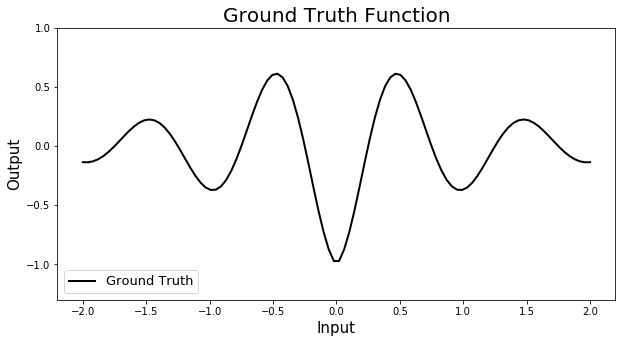

In [44]:
xmin,xmax = -2,2
x_target = np.linspace(start=xmin,stop=xmax,num=100).reshape((-1,1))
y_target = func_eval(x_target)
plot_line(
    x_target,y_target,fmt='-',lc='k',lw=2,label='Ground Truth',
    figsize=(10,5),xstr='Input',xfs=15,ystr='Output',yfs=15,tstr='Ground Truth Function',tfs=20,
    ylim=[-1.3,+1],
    lfs=13,lloc='lower left')

In [45]:
def sqrt_safe(x, eps=1e-6):
    return np.sqrt(np.abs(x)+eps)

def r_sq(x1, x2, x_range=1.0, invlen=5.0):
    x1_scaled, x2_scaled = invlen*x1/x_range, invlen*x2/x_range
    D_sq = distance.cdist(x1_scaled, x2_scaled, 'sqeuclidean')
    return D_sq 

def x_sampler(n_sample,x_minmax):
    """
    Sample x as a list from the input domain 
    """
    x_samples = []
    for _ in range(n_sample):
        x_sample = x_minmax[:,0]+(x_minmax[:,1]-x_minmax[:,0])*np.random.rand(1,x_minmax.shape[0])
        x_samples.append(x_sample)
    return x_samples # list

def Phi(x):
    """
    CDF(x)
    """
    return norm.cdf(x)

def scale_to_match_range(x_to_change,y_to_refer):
    """
    Scale the values of 'x_to_change' to match the range of 'y_to_refer'
    """
    x_to_change_scale = np.copy(x_to_change)
    xmin,xmax = np.min(x_to_change_scale),np.max(x_to_change_scale)
    ymin,ymax = np.min(y_to_refer),np.max(y_to_refer)
    x_to_change_scale = (ymax-ymin)*(x_to_change_scale-xmin)/(xmax-xmin)+ymin
    return x_to_change_scale

def get_sub_idx_from_unordered_set(K,n_sel,rand_rate=0.0):
    n_total = K.shape[0]
    remain_idxs = np.arange(n_total)
    sub_idx = np.zeros((n_sel))
    sum_K_vec = np.zeros(n_total)
    for i_idx in range(n_sel):
        if i_idx == 0:
            sel_idx = np.random.randint(n_total)
        else:
            curr_K_vec = K[(int)(sub_idx[i_idx-1]),:] 
            sum_K_vec = sum_K_vec + curr_K_vec
            k_vals = sum_K_vec[remain_idxs]
            min_idx = np.argmin(k_vals)
            sel_idx = remain_idxs[min_idx] 
            if rand_rate > np.random.rand():
                rand_idx = np.random.choice(len(remain_idxs),1,replace=False)  
                sel_idx = remain_idxs[rand_idx] 
        sub_idx[i_idx] = (int)(sel_idx)
        remain_idxs = np.delete(remain_idxs,np.argwhere(remain_idxs==sel_idx))
    sub_idx = sub_idx.astype(np.int64) # make it int
    return sub_idx

def get_x_sub_kdpp(x_minmax,n_sel,n_raw=10000,invlen=100):
    x_raw = np.asarray(x_sampler(n_sample=n_raw,x_minmax=x_minmax))[:,0,:]
    K = k_m52(x1=x_raw,x2=x_raw,x_range=x_minmax[:,1]-x_minmax[:,0],invlen=invlen) 
    sub_idx = get_sub_idx_from_unordered_set(K,n_sel=n_sel)
    x_sub = x_raw[sub_idx,:]
    return x_sub


In [46]:
def k_m52(x1, x2, x_range=1.0, gain=1.0, invlen=5.0):
    R_sq = r_sq(x1, x2, x_range=x_range, invlen=invlen)
    eps=1e-6
    K = gain*(1+sqrt_safe(5*R_sq)+(5.0/3.0)*R_sq)*np.exp(-sqrt_safe(5*R_sq))
    return K 

In [47]:
def gp_m52(x, y, x_test, x_minmax=None, gain=1.0, invlen=5.0, eps=1e-8):
    if x_minmax is None: 
        x_range = np.max(x, axis=0)-np.min[:,1]
    else:
        xmin, xmax = x_minmax[:,0], x_minmax[:,1]
        x_range = xmax-xmin 
    
    k_test = k_m52(x_test, x, x_range=x_range, gain=gain, invlen=invlen)
    K = k_m52(x, x, x_range, gain=gain, invlen=invlen)
    n = x.shape[0]
    inv_K = np.linalg.inv(K+eps*np.eye(n))
    mu_y = np.mean(y)
    mu_test = np.matmul(np.matmul(k_test, inv_K), y-mu_y)+mu_y 
    var_test = (gain-np.diag(np.matmul(np.matmul(k_test, inv_K), k_test.T))).reshape((-1,1))
    return mu_test, var_test
    

In [48]:
def ei_acquisition_function(x_bo,y_bo,x_test,x_minmax=None,SCALE_Y=True,gain=1.0,invlen=5.0,eps=1e-6):
    if SCALE_Y:
        y_bo_scaled = np.copy(y_bo)
        y_bo_mean = np.mean(y_bo_scaled)
        y_bo_scaled = y_bo_scaled - y_bo_mean
        y_min,y_max = np.min(y_bo_scaled), np.max(y_bo_scaled)
        y_range = y_max - y_min
        y_bo_scaled = 2.0 * y_bo_scaled / y_range
    else:
        y_bo_scaled = np.copy(y_bo)
    
    mu_test,var_test = gp_m52(x_bo,y_bo_scaled,x_test,x_minmax=x_minmax,gain=gain,invlen=invlen,eps=eps)
    gamma = (np.min(y_bo_scaled)-mu_test)/sqrt_safe(var_test)
    
    if SCALE_Y:
        mu_test = 0.5 * y_range * mu_test + y_bo_mean
        pi = 2.0 * sqrt_safe(var_test) * (gamma*Phi(gamma) + norm.pdf(mu_test,0,1))

    else: 
       pi = sqrt_safe(var_test) * (gamma*Phi(gamma) + norm.pdf(mu_test,0,1))

    return pi,mu_test,var_test



In [49]:
def get_best_xy(x_data,y_data):
    """
    Get the current best solution
    """
    min_idx = np.argmin(y_data)
    return x_data[min_idx,:].reshape((1,-1)),y_data[min_idx,:].reshape((1,-1))

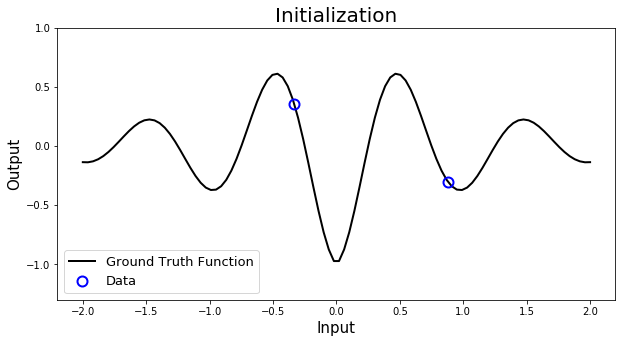

In [50]:
seed,x_minmax = 1,np.array([[xmin,xmax]])
max_step = 20

np.random.seed(seed=seed) # fix random seed 
xdim = x_minmax.shape[0]
x_data,y_data = np.zeros((0,xdim)),np.zeros((0,1))

# Random sampling
x_evals = x_sampler(n_sample=2,x_minmax=x_minmax)
y_evals = [func_eval(x=x_eval) for x_eval in x_evals] 
x_data = np.concatenate((x_data,np.asarray(x_evals)[:,0,:]),axis=0)
y_data = np.concatenate((y_data,np.asarray(y_evals)[:,0,:]),axis=0)
plot_line(
    x_target,y_target,fmt='-',lc='k',lw=2,label='Ground Truth Function',
    x2=x_data,y2=y_data,fmt2='o',lc2='b',lw2=1,ms2=10,mew2=2,label2='Data',
    figsize=(10,5),xstr='Input',xfs=15,ystr='Output',yfs=15,tstr='Initialization',tfs=20,
    ylim=[-1.3,+1],
    lfs=13,lloc='lower left')

In [51]:
np.random.seed(seed=seed) # fix random seed 
xdim = x_minmax.shape[0]
x_data,y_data = np.zeros((0,xdim)),np.zeros((0,1))

In [52]:
# Random sampling
x_evals = x_sampler(n_sample=2,x_minmax=x_minmax)
y_evals = [func_eval(x=x_eval) for x_eval in x_evals] 
x_data = np.concatenate((x_data,np.asarray(x_evals)[:,0,:]),axis=0)
y_data = np.concatenate((y_data,np.asarray(y_evals)[:,0,:]),axis=0)

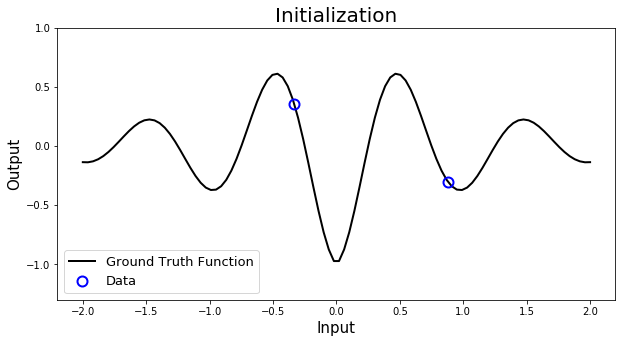

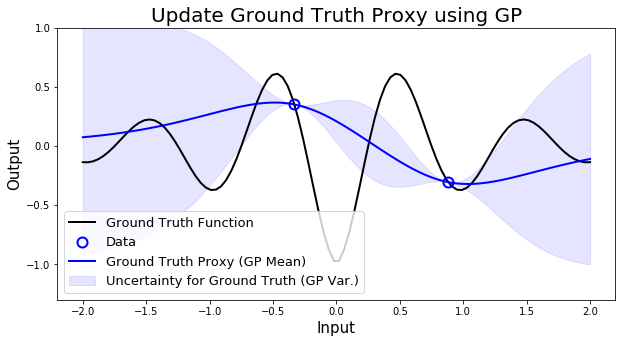

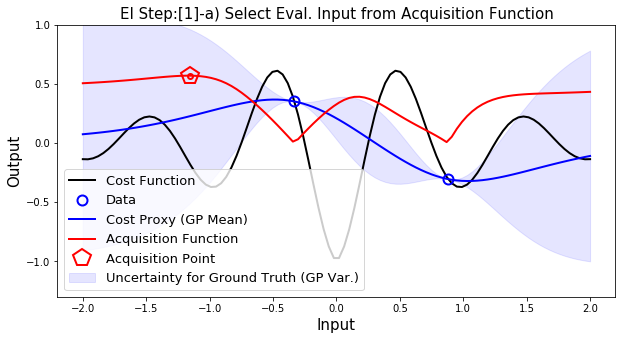

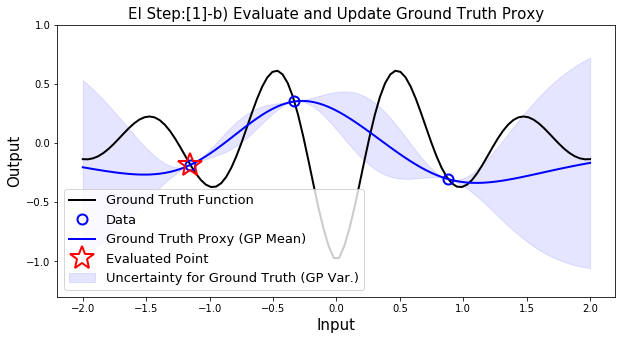

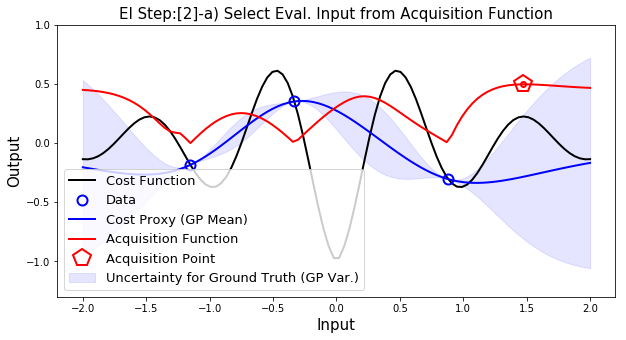

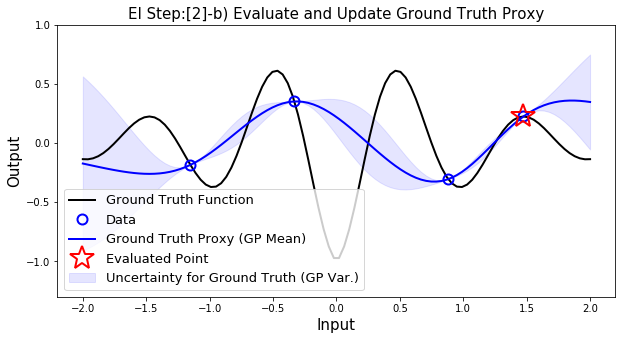

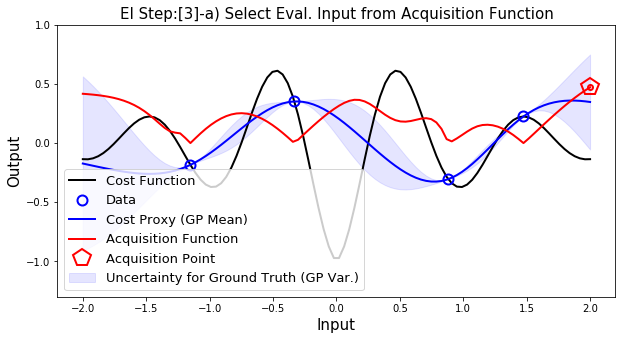

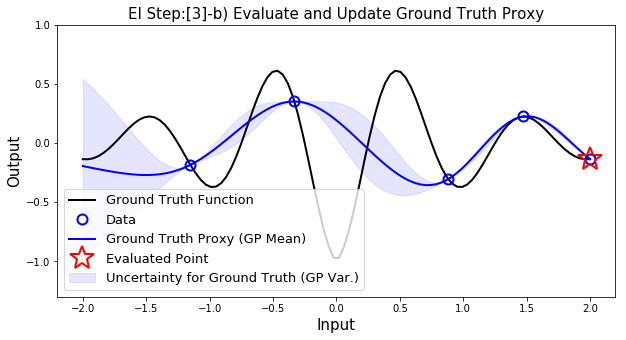

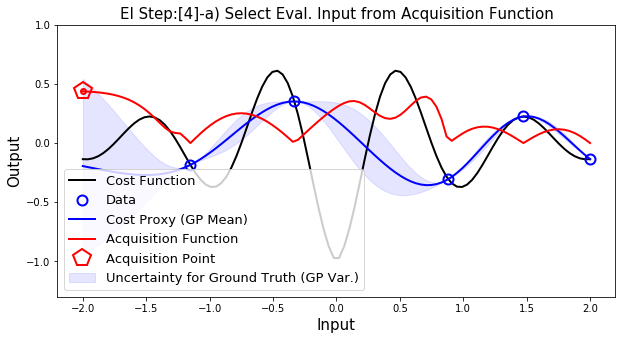

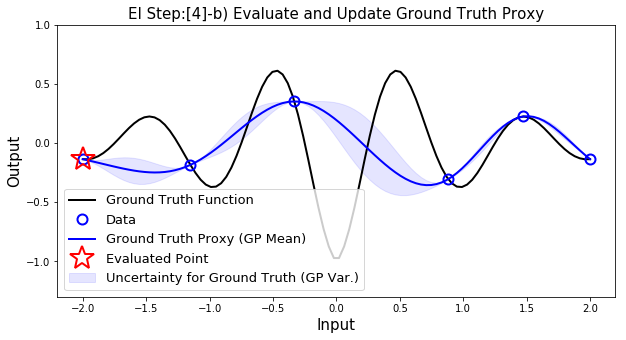

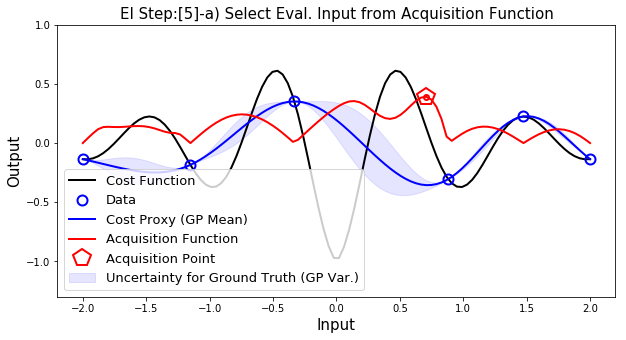

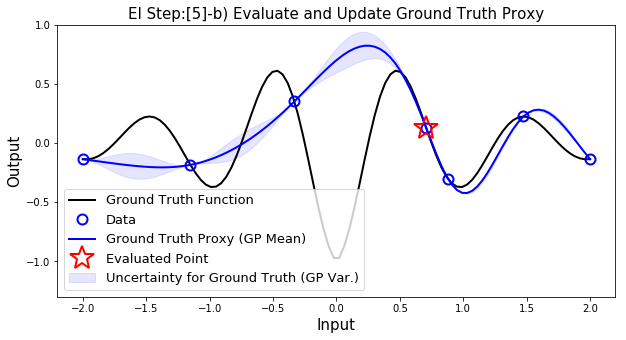

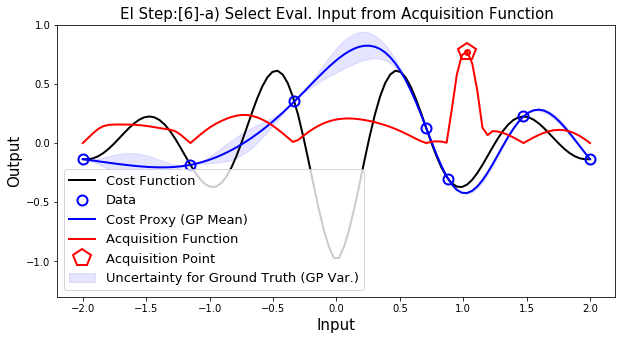

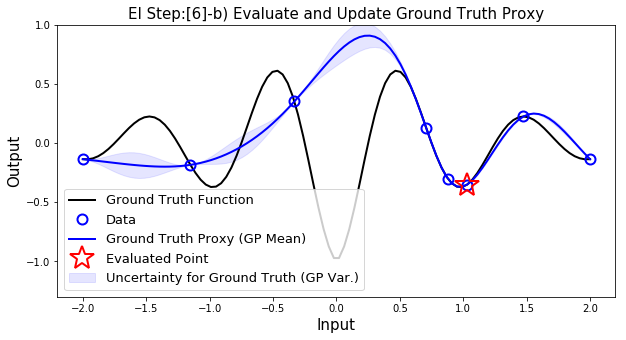

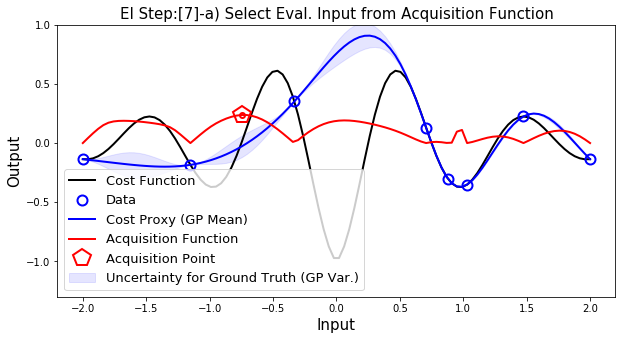

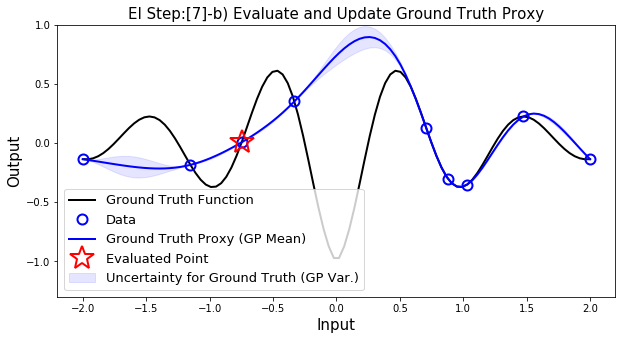

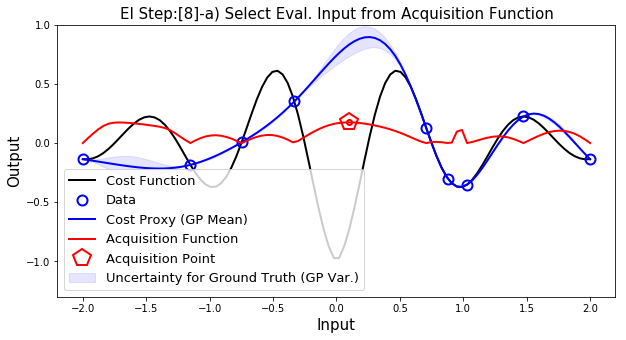

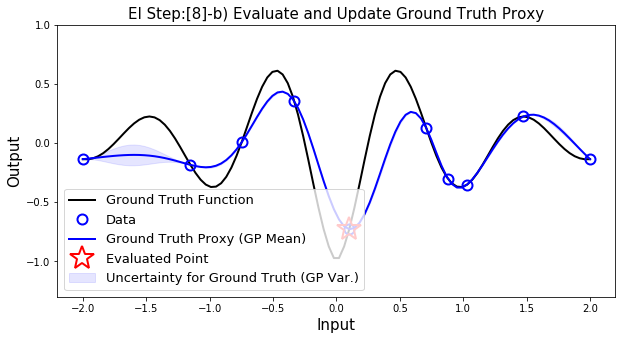

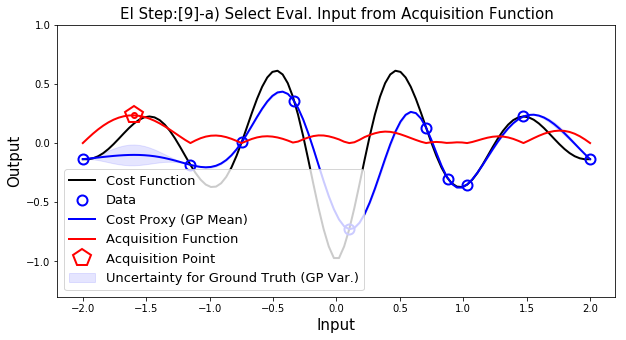

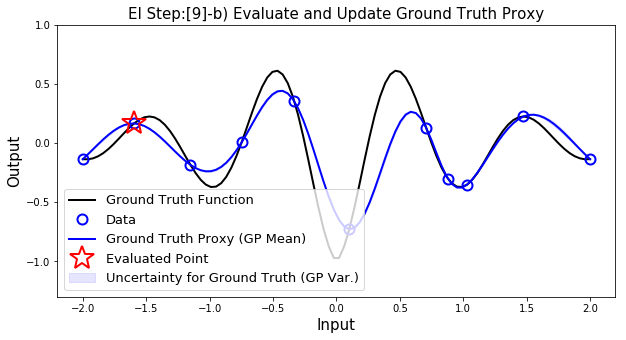

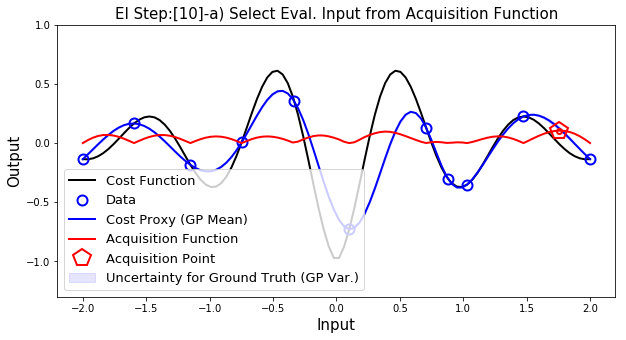

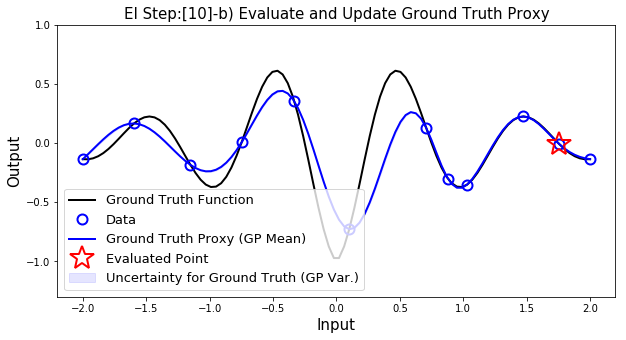

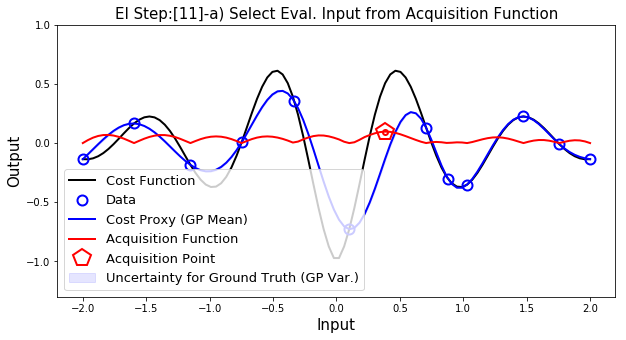

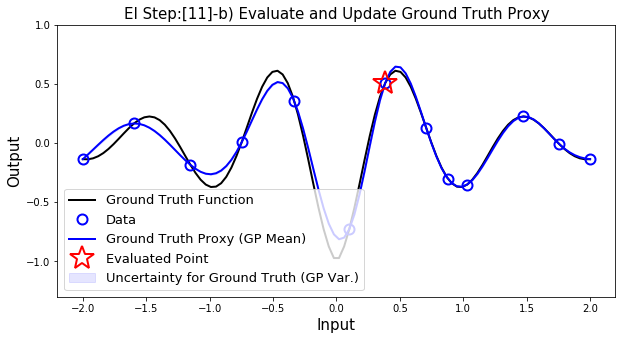

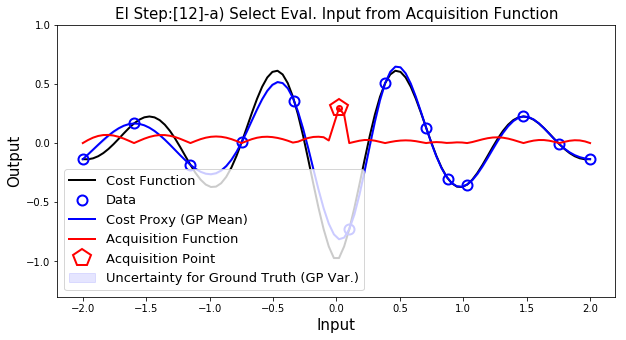

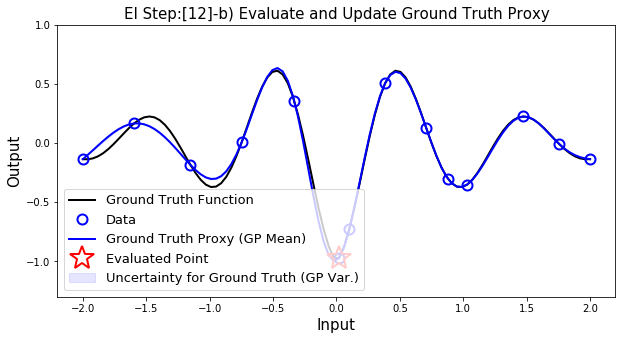

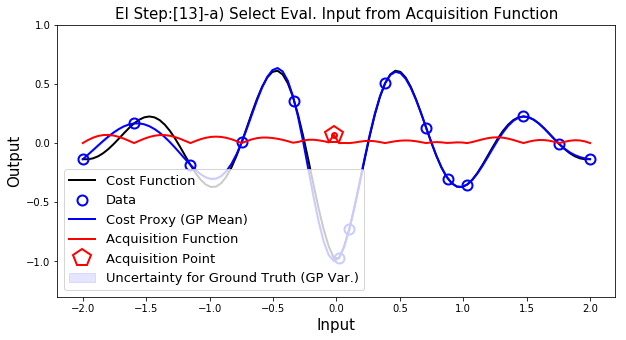

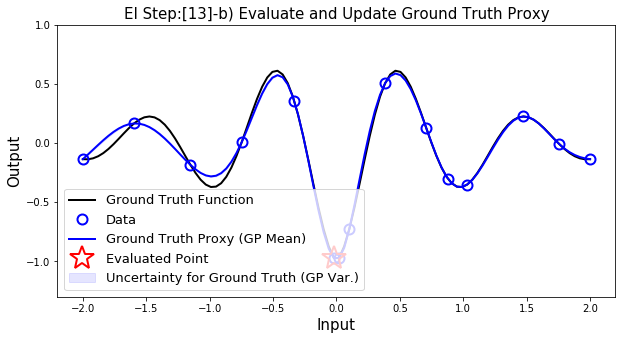

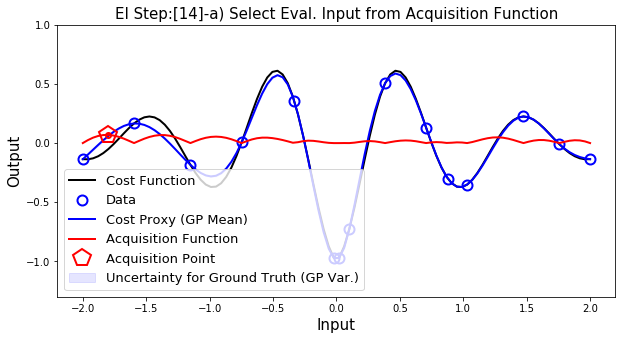

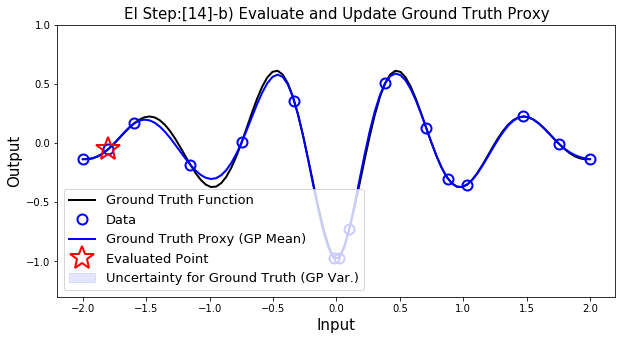

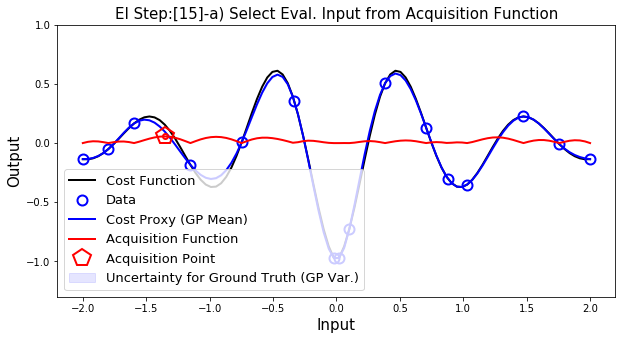

Inference Done.
Done.


In [53]:
np.random.seed(seed=seed) # fix random seed 
xdim = x_minmax.shape[0]
x_data,y_data = np.zeros((0,xdim)),np.zeros((0,1))
threshold = 0.07
# Random sampling
x_evals = x_sampler(n_sample=2,x_minmax=x_minmax)
y_evals = [func_eval(x=x_eval) for x_eval in x_evals] 
x_data = np.concatenate((x_data,np.asarray(x_evals)[:,0,:]),axis=0)
y_data = np.concatenate((y_data,np.asarray(y_evals)[:,0,:]),axis=0)
plot_line(
    x_target,y_target,fmt='-',lc='k',lw=2,label='Ground Truth Function',
    x2=x_data,y2=y_data,fmt2='o',lc2='b',lw2=1,ms2=10,mew2=2,label2='Data',
    figsize=(10,5),xstr='Input',xfs=15,ystr='Output',yfs=15,tstr='Initialization',tfs=20,
    ylim=[-1.3,+1],
    lfs=13,lloc='lower left')

for it in range(max_step):
    
    # Bayesian Optimization
    invlen,eps = 5.0,1e-10
    x_test = np.linspace(start=xmin,stop=xmax,num=100).reshape((-1,1))
    a_ei,mu_test,var_test = ei_acquisition_function(
        x_data,y_data,x_test,x_minmax=x_minmax,SCALE_Y=True,gain=1.0,invlen=invlen,eps=eps)
    max_idx = np.argmax(a_ei)  
    x_bo = x_test[max_idx,:].reshape((1,-1)) # find the maxima
    y_ei = a_ei[max_idx,0] # acquisition function 
    
    if it == 0:
        plot_line(
            x_target,y_target,fmt='-',lc='k',lw=2,label='Ground Truth Function',
            x2=x_data,y2=y_data,fmt2='o',lc2='b',lw2=1,ms2=10,mew2=2,label2='Data',
            x3=x_test,y3=mu_test,fmt3='-',lc3='b',label3='Ground Truth Proxy (GP Mean)',
            x_fb=x_test,y_fb_low=mu_test-var_test,y_fb_high=mu_test+var_test,fba=0.1,fbc='b',labelfb='Uncertainty (GP Var.)',
            figsize=(10,5),xstr='Input',xfs=15,ystr='Output',yfs=15,tstr='Update Ground Truth Proxy using GP',tfs=20,
            ylim=[-1.3,+1],
            lfs=13,lloc='lower left')
    
    # Select Eval. Input from Acquisition Function
    plot_line(
        x_target,y_target,fmt='-',lc='k',lw=2,label='Ground Truth Function',
        x2=x_data,y2=y_data,fmt2='o',lc2='b',lw2=1,ms2=10,mew2=2,label2='Data',
        x3=x_test,y3=mu_test,fmt3='-',lc3='b',lw3=2,label3='Ground Truth Proxy (GP Mean)',
        x_fb=x_test,y_fb_low=mu_test-var_test,y_fb_high=mu_test+var_test,fba=0.1,fbc='b',labelfb='Uncertainty (GP Var.)',
        x4=x_test,y4=a_ei,fmt4='-',lc4='r',label4='Acquisition Function',
        x5=x_bo,y5=y_ei,fmt5='p',lc5='r',lw5=2,ms5=18,mew5=2,label5='Acquisition Point',
        x6=x_bo,y6=y_ei,fmt6='o',lc6='r',lw6=2,ms6=5,mew6=2,label6=None,
        figsize=(10,5),xstr='Input',xfs=15,ystr='Output',yfs=15,
        tstr='EI Step:[%d]-a) Select Eval. Input from Acquisition Function'%(it+1),tfs=15,
        ylim=[-1.3,+1],
        lfs=13,lloc='lower left')
    
    # Evaluate the point selected from BO and update the acquisition function 
    y_bo = func_eval(x_bo)
    x_data = np.concatenate((x_data,x_bo),axis=0)
    y_data = np.concatenate((y_data,y_bo),axis=0)
    a_ei,mu_test,var_test, = ei_acquisition_function(
        x_data,y_data,x_test,x_minmax=x_minmax,SCALE_Y=True,gain=1.0,invlen=invlen,eps=eps)
    if np.max(abs(y_target-mu_test))<threshold:
        print("Inference Done.")
        break 
    # Evaluate and Update the Target Proxy
    plot_line(
        x_target,y_target,fmt='-',lc='k',lw=2,label='Ground Truth Function',
        x2=x_data,y2=y_data,fmt2='o',lc2='b',lw2=1,ms2=10,mew2=2,label2='Data',
        x3=x_test,y3=mu_test,fmt3='-',lc3='b',lw3=2,label3='Ground Truth Proxy (GP Mean)',
        x_fb=x_test,y_fb_low=mu_test-var_test,y_fb_high=mu_test+var_test,fba=0.1,fbc='b',labelfb='Uncertainty (GP Var.)',
        x5=x_bo,y5=y_bo,fmt5='*',lc5='r',lw5=2,ms5=25,mew5=2,label5='Evaluated Point',
        figsize=(10,5),xstr='Input',xfs=15,ystr='Output',yfs=15,
        tstr='EI Step:[%d]-b) Evaluate and Update Ground Truth Proxy'%(it+1),tfs=15,
        ylim=[-1.3,+1],
        lfs=13,lloc='lower left')
    
print ("Done.")